In [1]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
%matplotlib inline

# Read and Explore

### the images are a matrix of 28x28 pixels, each one of the pixels are assigned as a column

In [2]:
df_train = pd.read_csv('train.csv')

In [3]:
df_train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
df_train['label'].value_counts().sort_index()

0    4132
1    4684
2    4177
3    4351
4    4072
5    3795
6    4137
7    4401
8    4063
9    4188
Name: label, dtype: int64

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [6]:
pixel_size = int(784**0.5)

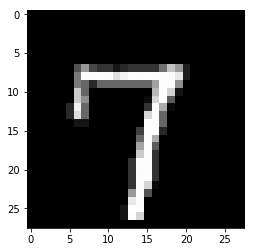

In [7]:
temp_list = []
num = 6
for i in df_train.columns[1:]:
    temp_list.append(df_train.loc[num,i])
temp_list = np.reshape(np.array(temp_list), (pixel_size,pixel_size))/255
plt.imshow(temp_list, 'gray')

# Pre-Process the Data

In [8]:
def image_prepro(df_x):
    total_list = []
    for num in tqdm(range(len(df_x))):
        temp_list = []
        for col in df_x.columns[1:]:
            temp_list.append(df_x.loc[num,col])
        temp_list = np.array(temp_list)    
        temp_list = np.reshape(temp_list, (pixel_size,pixel_size))/255
        total_list.append(temp_list)
    return total_list

In [9]:
df_train['Pixel_Array'] = image_prepro(df_train)
df_train = df_train[['label','Pixel_Array']]

100%|███████████████████████████████████████████████████████████████████████████| 42000/42000 [06:39<00:00, 105.22it/s]


In [10]:
df_train.head()

,label,Pixel_Array
0,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


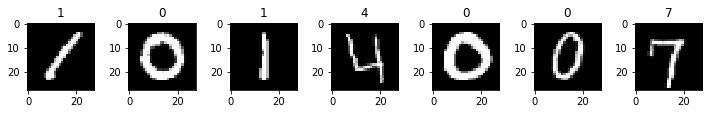

In [11]:
rows = 1
cols = 7
axes=[]
fig=plt.figure(figsize=(10,10))

for a in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, a+1))
    subplot_title=(df_train.loc[a,'label'])
    axes[-1].set_title(subplot_title)
    plt.imshow(df_train.loc[a,'Pixel_Array'], cmap='gray')
    
fig.tight_layout()    
plt.show()

# Splitting Data

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X = [value[1][1] for value in tqdm(df_train.iterrows())]
X = np.array(X)
X = np.reshape(X,(-1,pixel_size, pixel_size,1))
y = df_train['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=101)

42000it [00:09, 4232.73it/s]


In [14]:
X.shape

(42000, 28, 28, 1)

In [15]:
y_train.shape

(35700,)

In [16]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [20]:
model_checkpoint_callback = ModelCheckpoint(filepath='best_model.h5', save_weights_only=True,
                                            monitor='val_acc', mode='max', save_best_only=True,verbose=1)

model_earlystopping_callback = EarlyStopping(monitor='val_loss', patience=2)

model_plateau_callback = ReduceLROnPlateau(monitor='val_loss', patience=1)

callback_list = [model_checkpoint_callback, model_earlystopping_callback, model_plateau_callback]

In [21]:
model = Sequential()

model.add(Conv2D(64,(3,3),activation='relu',input_shape=(pixel_size,pixel_size,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(128,(5,5),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Conv2D(256,(3,3),activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#model.load_weights('best_model.h5')

In [22]:
model.fit(X_train, y_train, batch_size=32, epochs=20, callbacks=callback_list, validation_split=0.15)

Train on 30345 samples, validate on 5355 samples
Epoch 1/20
30345/30345 [==============================] - 110s 4ms/step - loss: 0.2700 - acc: 0.9177 - val_loss: 0.0963 - val_acc: 0.9737

Epoch 00001: val_acc improved from -inf to 0.97367, saving model to best_model.h5
Epoch 2/20
30345/30345 [==============================] - 105s 3ms/step - loss: 0.1079 - acc: 0.9678 - val_loss: 0.0504 - val_acc: 0.9862

Epoch 00002: val_acc improved from 0.97367 to 0.98618, saving model to best_model.h5
Epoch 3/20
30345/30345 [==============================] - 104s 3ms/step - loss: 0.0808 - acc: 0.9751 - val_loss: 0.0510 - val_acc: 0.9864

Epoch 00003: val_acc improved from 0.98618 to 0.98637, saving model to best_model.h5
Epoch 4/20
30345/30345 [==============================] - 112s 4ms/step - loss: 0.0503 - acc: 0.9839 - val_loss: 0.0368 - val_acc: 0.9895

Epoch 00004: val_acc improved from 0.98637 to 0.98954, saving model to best_model.h5
Epoch 5/20
30345/30345 [==============================] - 

# Results Exploration

In [23]:
df_model = pd.DataFrame(model.history.history)

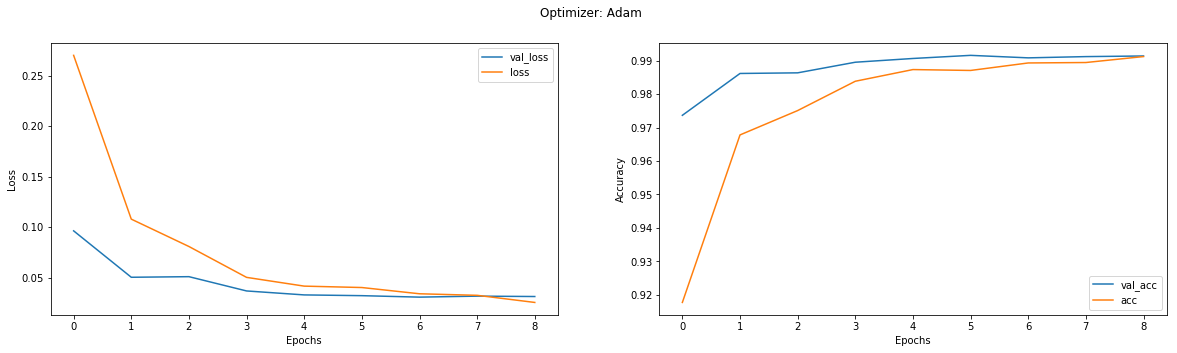

In [26]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.suptitle('Optimizer: Adam')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(df_model['val_loss'])
plt.plot(df_model['loss'])
plt.legend(loc=1)

plt.subplot(1,2,2)
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.plot(df_model['val_acc'])
plt.plot(df_model['acc'])
plt.legend(loc=4)

In [27]:
predictions = model.predict_classes(X_test)

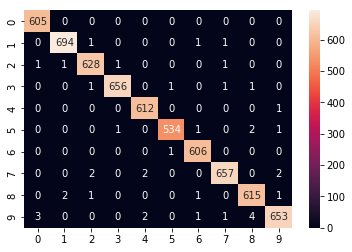

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

cf_matrix = confusion_matrix(y_test, predictions)
sns.heatmap(cf_matrix, annot=True, fmt='g')

In [29]:
print(classification_report(y_test, predictions))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       605
          1       1.00      1.00      1.00       697
          2       0.99      0.99      0.99       632
          3       1.00      0.99      1.00       660
          4       0.99      1.00      1.00       613
          5       1.00      0.99      0.99       539
          6       0.99      1.00      1.00       607
          7       0.99      0.99      0.99       663
          8       0.99      0.99      0.99       620
          9       0.99      0.98      0.99       664

avg / total       0.99      0.99      0.99      6300



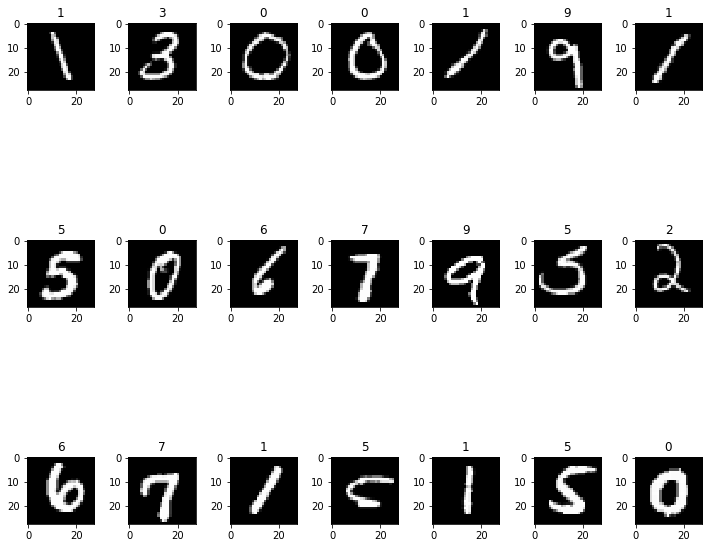

In [30]:
rows = 3
cols = 7
axes=[]
fig=plt.figure(figsize=(10,10))

for a in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, a+1))
    subplot_title=(predictions[a])
    axes[-1].set_title(subplot_title)
    plt.imshow(np.reshape(X_test[a], (pixel_size,pixel_size)), cmap='gray')
fig.tight_layout()    
plt.show()

# Kaggle Submission File

In [31]:
df_test = pd.read_csv('test.csv')

def image_prepro(df_x):
    total_list = []
    for num in tqdm(range(len(df_x))):
        temp_list = []
        for col in df_x.columns:
            temp_list.append(df_x.loc[num,col])
        temp_list = np.array(temp_list)    
        temp_list = np.reshape(temp_list, (pixel_size,pixel_size))/255
        total_list.append(temp_list)
    return total_list

df_test['Pixel_Array'] = image_prepro(df_test)

X = [value[1][-1] for value in tqdm(df_test.iterrows())]
X = np.array(X)
X = np.reshape(X,(-1,pixel_size, pixel_size,1))

predictions = model.predict_classes(X)

df_sub = pd.DataFrame(columns=['ImageId'])
df_sub['ImageId'] = list(range(1,28001))
df_sub['Label'] = predictions.tolist()
df_sub.index += 1 
df_sub.to_csv('sub_file.csv',index=False)

100%|███████████████████████████████████████████████████████████████████████████| 28000/28000 [04:35<00:00, 101.52it/s]
28000it [00:05, 4918.56it/s]
